In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install --upgrade git+https://github.com/keras-team/keras-cv -q

In [2]:
import os
from tqdm.auto import tqdm
import xml.etree.ElementTree as ET

import tensorflow as tf
from tensorflow import keras
from itertools import chain
import matplotlib.pyplot as plt
import cv2
from PIL import Image


import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using TensorFlow backend


In [3]:
images_folder = "/kaggle/input/poultry-disease-resize/"

In [4]:
def fix_path(path,folder_target):
    path_ = path.split(".")
    return(folder_target + path_[0] + "/" + path)

def load_folder(images_folder):
    images_folder_fix = []
    class_file = os.listdir(images_folder)
    for i in class_file:
        images_folder_fix.append(os.listdir(images_folder + i))

    images_folder_fix = list(chain(*images_folder_fix))
    return images_folder_fix

In [5]:
class_ids = [
    "salmo",
    'cocci',
    'healthy',
    'ncd',
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))
class_mapping

{0: 'salmo', 1: 'cocci', 2: 'healthy', 3: 'ncd'}

In [6]:
images_path = [fix_path(i,images_folder) for i in load_folder(images_folder)]

In [7]:
import pickle
def load_from_pickle(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data['classes'], data['bounding_boxes']

classes, bbox = load_from_pickle("/kaggle/input/annotations-fix-resize/data.pkl")

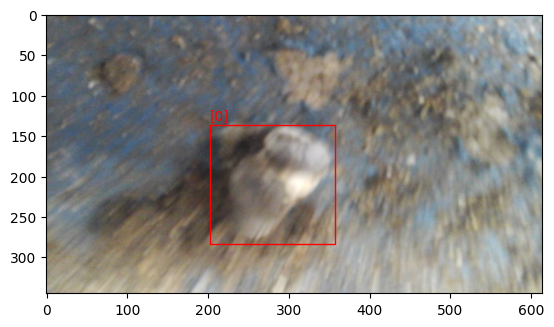

In [8]:
import cv2
import matplotlib.pyplot as plt

def annotate_image(image_path, classes, bounding_boxes):
    # Read the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Create figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(image_rgb)

    # Add bounding boxes and labels
    for class_index, bbox in zip(classes, bounding_boxes):
        #class_label = classes[class_index]
        
        rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(bbox[0], bbox[1] - 5, classes, color='r')

    # Show the plot
    plt.show()

# Example usage
annotate_image(images_path[0], classes[0], bbox[0])

In [9]:
import pandas as pd
df = pd.DataFrame({"images_path":images_path,"class":[i.split("/")[-2] for i in images_path ]})
from sklearn.model_selection import train_test_split
X = df.images_path
y = df['class']
X_train,X_val,y_train,y_val = train_test_split(X,y,stratify = y,random_state = 42,test_size = 0.2)
train_idx = y_train.index
val_idx = y_val.index

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [10]:
train_idx

Index([5529, 2887, 5378, 3778, 3582, 2736, 6251, 5653, 3038, 3942,
       ...
       5526,  966, 1437, 5122, 2189, 1175, 3827, 6025, 5388, 6476],
      dtype='int64', length=5449)

In [11]:
SPLIT_RATIO = 0.2
BATCH_SIZE = 16
LEARNING_RATE = 0.001
EPOCH = 100
GLOBAL_CLIPNORM = 10.0

In [12]:
def get_subset(images,bbox,classes,idx):
    images_path_ = tf.ragged.constant([images[x] for x in idx])
    bbox_ = tf.ragged.constant([bbox[x] for x in idx])
    classes_ = tf.ragged.constant([classes[x] for x in idx])
    
    data = tf.data.Dataset.from_tensor_slices((images_path_,classes_,bbox_))
    return data

train_data = get_subset(images_path,bbox,classes,train_idx)
val_data = get_subset(images_path,bbox,classes,val_idx)

In [13]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

In [14]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.JitteredResize(
            target_size=(256, 256),
            scale_factor = (0.3,0.5),
            bounding_box_format="xywh",
        ),
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xywh"),
#         keras_cv.layers.RandomShear(
#             x_factor=0.2, y_factor=0.2, bounding_box_format="xywh"
#         ),

    ]
)
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

In [15]:
resizing = keras_cv.layers.JitteredResize(
            target_size=(256, 256),
            scale_factor=(0.3, 0.5),
            bounding_box_format="xywh",
        )
# resizing = keras_cv.layers.Resizing(
#     256,
#     256,
#     interpolation="bilinear",
#     pad_to_aspect_ratio=True,
#     bounding_box_format="xywh",
# )

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

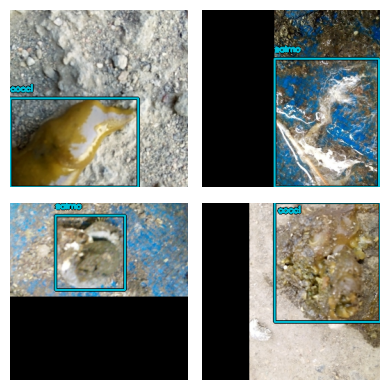

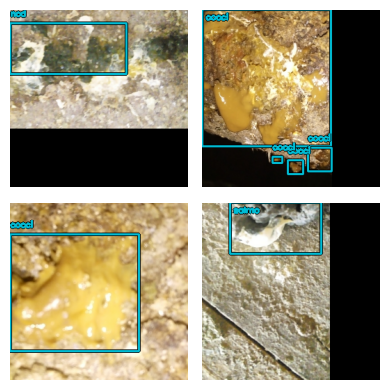

In [16]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        font_scale=0.4,
        bounding_box_format=bounding_box_format,
        class_mapping = class_mapping
    )


visualize_dataset(
    train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

visualize_dataset(
    val_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

In [17]:
def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=5
    )


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [18]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_xs_backbone_coco"
)

In [19]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xywh",
    backbone=backbone,
    fpn_depth=2,
)

In [20]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    global_clipnorm=GLOBAL_CLIPNORM,
    amsgrad = True
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

In [21]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xywh",
            evaluate_freq=1e9,
        )
        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > 0.46:
            self.best_map = current_map
            self.model.save(self.save_path)
            self.model.stop_training = True
            # Save the model when mAP improves

        return logs

In [ ]:
pip install pycocotools

# Training Model

In [22]:
yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[EvaluateCOCOMetricsCallback(val_ds, "yolo_v8_xs_backbone_coco.h5")],
)

Epoch 1/100
340/340 [==============================] - 135s 239ms/step - loss: 26.7184 - box_loss: 2.9123 - class_loss: 23.8062 - val_loss: 4.0653 - val_box_loss: 2.8905 - val_class_loss: 1.1748 - MaP: 0.0128 - MaP@[IoU=50]: 0.0699 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0176 - Recall@[max_detections=1]: 0.0410 - Recall@[max_detections=10]: 0.0410 - Recall@[max_detections=100]: 0.0410 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0567
Epoch 2/100
340/340 [==============================] - 73s 214ms/step - loss: 3.4880 - box_loss: 2.5742 - class_loss: 0.9138 - val_loss: 3.4581 - val_box_loss: 2.5943 - val_class_loss: 0.8638 - MaP: 0.0047 - MaP@[IoU=50]: 0.0139 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0107 - Recall@[max_detections=1]: 0.0043 - Recall@[max_detections=10]: 0.0043 - Recall@[max_detectio

In [23]:
yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[EvaluateCOCOMetricsCallback(val_ds, "yolo_v8_xs_backbone_coco.h5")],
)

Epoch 1/20
340/340 [==============================] - 75s 218ms/step - loss: 1.0759 - box_loss: 0.9148 - class_loss: 0.1611 - val_loss: 1.2485 - val_box_loss: 1.0637 - val_class_loss: 0.1848 - MaP: 0.4481 - MaP@[IoU=50]: 0.6875 - MaP@[IoU=75]: 0.4676 - MaP@[area=small]: 0.1813 - MaP@[area=medium]: 0.4531 - MaP@[area=large]: 0.5514 - Recall@[max_detections=1]: 0.4688 - Recall@[max_detections=10]: 0.5211 - Recall@[max_detections=100]: 0.5211 - Recall@[area=small]: 0.2207 - Recall@[area=medium]: 0.5186 - Recall@[area=large]: 0.6304
Epoch 2/20
340/340 [==============================] - 74s 217ms/step - loss: 1.0869 - box_loss: 0.9259 - class_loss: 0.1609 - val_loss: 1.2769 - val_box_loss: 1.0880 - val_class_loss: 0.1889 - MaP: 0.4416 - MaP@[IoU=50]: 0.7055 - MaP@[IoU=75]: 0.4565 - MaP@[area=small]: 0.1746 - MaP@[area=medium]: 0.4560 - MaP@[area=large]: 0.5287 - Recall@[max_detections=1]: 0.4698 - Recall@[max_detections=10]: 0.5223 - Recall@[max_detections=100]: 0.5223 - Recall@[area=small]

In [24]:
yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[EvaluateCOCOMetricsCallback(val_ds, "yolo_v8_xs_backbone_coco.h5")],
)

Epoch 1/20
340/340 [==============================] - 73s 214ms/step - loss: 1.0389 - box_loss: 0.8892 - class_loss: 0.1497 - val_loss: 1.2790 - val_box_loss: 1.0884 - val_class_loss: 0.1906 - MaP: 0.4477 - MaP@[IoU=50]: 0.7005 - MaP@[IoU=75]: 0.4705 - MaP@[area=small]: 0.1885 - MaP@[area=medium]: 0.4392 - MaP@[area=large]: 0.5690 - Recall@[max_detections=1]: 0.4838 - Recall@[max_detections=10]: 0.5287 - Recall@[max_detections=100]: 0.5287 - Recall@[area=small]: 0.2318 - Recall@[area=medium]: 0.5161 - Recall@[area=large]: 0.6549
Epoch 2/20
340/340 [==============================] - 75s 219ms/step - loss: 1.0301 - box_loss: 0.8817 - class_loss: 0.1484 - val_loss: 1.2806 - val_box_loss: 1.0862 - val_class_loss: 0.1943 - MaP: 0.4440 - MaP@[IoU=50]: 0.6732 - MaP@[IoU=75]: 0.4800 - MaP@[area=small]: 0.1896 - MaP@[area=medium]: 0.4422 - MaP@[area=large]: 0.5440 - Recall@[max_detections=1]: 0.4802 - Recall@[max_detections=10]: 0.5296 - Recall@[max_detections=100]: 0.5296 - Recall@[area=small]

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


340/340 [==============================] - 77s 225ms/step - loss: 1.0158 - box_loss: 0.8695 - class_loss: 0.1463 - val_loss: 1.2293 - val_box_loss: 1.0498 - val_class_loss: 0.1795 - MaP: 0.4681 - MaP@[IoU=50]: 0.7298 - MaP@[IoU=75]: 0.4896 - MaP@[area=small]: 0.2132 - MaP@[area=medium]: 0.4627 - MaP@[area=large]: 0.5581 - Recall@[max_detections=1]: 0.4938 - Recall@[max_detections=10]: 0.5425 - Recall@[max_detections=100]: 0.5425 - Recall@[area=small]: 0.2886 - Recall@[area=medium]: 0.5252 - Recall@[area=large]: 0.6294


1/1 [==============================] - 0s 66ms/step


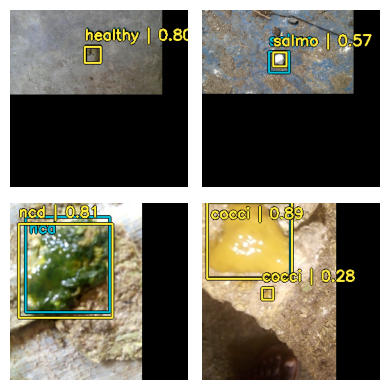

In [25]:

def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(2)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=2,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )


visualize_detections(yolo, dataset=val_ds, bounding_box_format="xywh")

# Loading Model

In [26]:
model= tf.keras.models.load_model("/kaggle/input/yolov8-model/yolo_v8_xs_backbone_coco (2).h5",
    custom_objects={
    "YOLOV8Detector": keras_cv.models.YOLOV8Detector,
    "YOLOV8Backbone": keras_cv.models.YOLOV8Backbone
            },
    compile = False)

1/1 [==============================] - 0s 65ms/step


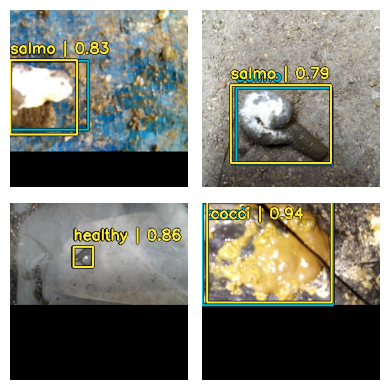

In [41]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(2)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=2,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )


visualize_detections(model, dataset=val_ds, bounding_box_format="xywh")